In [17]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import normalize
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score,RocCurveDisplay
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.stats import zscore
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier

In [18]:
df=pd.read_csv('train.csv')
dt=pd.read_csv('test.csv')

In [19]:
#Observamos que las ultimas 4 columnas tienen valores invalidos lo que puede generar problemas al modelo de entrenamiento
#remplazamos cada valor referido a esto
df.replace(-99,np.nan,inplace=True) #La función replace() es un método de Pandas que permite reemplazar valores específicos en un DataFrame o en una Serie.
#Ademas puede haber valores faltantes por lo que completamos eñ codigo con estos valores tomando la mediana de cada columna
df.fillna(df.median(),inplace=True) #es un método de Pandas que se utiliza para reemplazar los valores faltantes (NaN) en un DataFrame
df = df[(np.abs(zscore(df.select_dtypes(include=[np.number]))) < 3).all(axis=1)]
#Observamos que las ultimas 4 columnas tienen valores invalidos lo que puede generar problemas al modelo de entrenamiento
#remplazamos cada valor referido a esto
dt.replace(-99,np.nan,inplace=True)
#Ademas puede haber valores faltantes por lo que completamos eñ codigo con estos valores tomando la mediana de cada columna
dt.fillna(dt.mean(),inplace=True)
#Repito lo de arriba pues si entreno testeo

In [20]:
df.set_index('ID',inplace=True)
dt.set_index('ID',inplace=True )

In [21]:
#Ahora, como queremos que diferencie entre estrella, galaxia o cuasar, utilizamos las magnitudes
Bandas=['umag','gmag','rmag','imag','zmag','Ymag','Jmag','Hmag','Kmag','W1mag','W2mag'] #Estas solas magnitudes totales
#Elegimos en principio estas bandas 
#La función len() devuelve la cantidad de elementos en una lista
for i in range(len(Bandas)-1):
    df[f'{Bandas[i]}-{Bandas[i+1]}']=df[Bandas[i]]-df[Bandas[i+1]]
    dt[f'{Bandas[i]}-{Bandas[i+1]}']=dt[Bandas[i]]-dt[Bandas[i+1]]
Bandas_rad=['u3mag','g3mag','r3mag','i3mag','Z3mag','Y3mag','J3mag','H3mag','K3mag']
#Ahora en la misma linea de codigo, haremos lo mismo para las magnitudes a radio constante 3arcsecond
for i in range(len(Bandas_rad)-1):
    df[f'{Bandas_rad[i]}-{Bandas_rad[i+1]}']=df[Bandas_rad[i]]-df[Bandas_rad[i+1]]
    dt[f'{Bandas_rad[i]}-{Bandas_rad[i+1]}']=dt[Bandas_rad[i]]-dt[Bandas_rad[i+1]]
Bandas_HLR=['Yhlr','Jhlr','Hhlr','Khlr']
for i in range(len(Bandas_HLR)-1):
    df[f'{Bandas_HLR[i]}-{Bandas_HLR[i+1]}']=df[Bandas_HLR[i]]-df[Bandas_HLR[i+1]]
    dt[f'{Bandas_HLR[i]}-{Bandas_HLR[i+1]}']=dt[Bandas_HLR[i]]-dt[Bandas_HLR[i+1]]
df['W1mag/W2mag'] = df['W1mag'] / df['W2mag']
df['umag/gmag'] = df['umag'] / df['gmag']
df['gmag/rmag'] = df['gmag'] / df['rmag']
df['rmag/imag'] = df['rmag'] / df['imag']
df['Hmag/Kmag'] = df['Hmag'] / df['Kmag']
df['Jmag/Hmag'] = df['Jmag'] / df['Hmag']
dt['W1mag/W2mag'] = dt['W1mag'] / dt['W2mag']
dt['umag/gmag'] = dt['umag'] / dt['gmag']
dt['gmag/rmag'] = dt['gmag'] / dt['rmag']
dt['rmag/imag'] = dt['rmag'] / dt['imag']
dt['Hmag/Kmag'] = dt['Hmag'] / dt['Kmag']
dt['Jmag/Hmag'] = dt['Jmag'] / dt['Hmag']

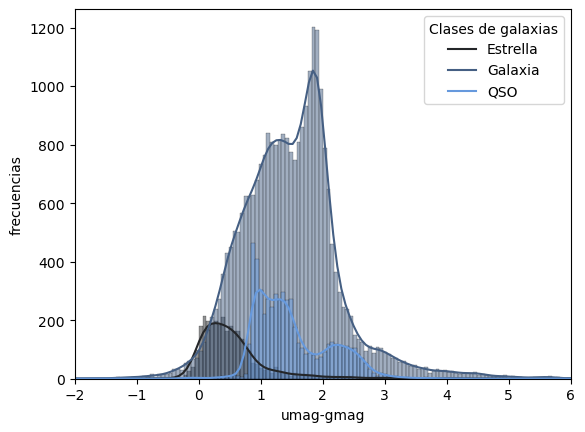

In [22]:
palette=sns.dark_palette("#69d", reverse=True, as_cmap=True)
sns.histplot(df, x='umag-gmag', hue='Hclass', kde=True, palette=palette)  
plt.xlim(-2,6)
plt.ylabel('frecuencias')

plt.legend(title='Clases de galaxias', labels=['Estrella', 'Galaxia', 'QSO'])
plt.show()

In [23]:
df['Hclass'].value_counts()

Hclass
1    27325
0     5714
2     3132
Name: count, dtype: int64

In [24]:
#Tengo que definir mis feature, mis variables de entrada, estas son las que utilizamos para entrenar el modelo
features = ['umag', 'gmag', 'rmag', 'imag', 'zmag', 'Ymag', 'Jmag', 'Hmag', 'Kmag', 'W1mag', 'W2mag', 
            'umag-gmag', 'gmag-rmag', 'rmag-imag', 'imag-zmag', 'zmag-Ymag', 'Ymag-Jmag', 'Jmag-Hmag', 
            'Hmag-Kmag', 'W1mag-W2mag', 'g3mag-r3mag', 'r3mag-i3mag', 
            'i3mag-Z3mag', 'Z3mag-Y3mag', 'Y3mag-J3mag', 'J3mag-H3mag', 'H3mag-K3mag','W1mag/W2mag', 'umag/gmag', 'gmag/rmag', 'rmag/imag', 'Hmag/Kmag', 'Jmag/Hmag']
#Me quedo con mis mejores estimadores
#features = [
#            'umag-gmag', 'gmag-rmag', 'rmag-imag', 'Ymag-Jmag', 'Jmag-Hmag', 
#            'Hmag-Kmag', 'W1mag-W2mag', 'g3mag-r3mag', 'r3mag-i3mag',
#             'Z3mag-Y3mag', 'Y3mag-J3mag', 'J3mag-H3mag', 'H3mag-K3mag']

In [25]:
df_tr, df_te=train_test_split(df,test_size=0.3,random_state=42)
#Divide el conjunto de datos en entrenamiento (70%) y prueba (30%)

In [26]:
#Ahora dividimos en clases de entrenamiento
X_train = df_tr[features]
y_train = df_tr['Hclass']

#lo mismo con el testeo
X_test=df_te[features]
y_test=df_te['Hclass']

In [27]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
gbc = GradientBoostingClassifier(random_state=42)
gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_test)
print(" Reporte de clasificación ")
print(classification_report(y_test, y_pred))
print("Matriz de confusión ")
print(confusion_matrix(y_test, y_pred))
print( "Precisión general")
print(accuracy_score(y_test, y_pred))



In [ ]:
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])  
y_proba = gbc.predict_proba(X_test)
roc_auc = roc_auc_score(y_test_bin, y_proba, average="'weighted'", multi_class="ovr")
print(f" ROC-AUC",roc_auc) 
fpr, tpr, thresholds = roc_curve(y_test_bin, y_proba)

 ROC-AUC 0.9963600824568267


In [ ]:
f1_score(y_test,y_pred,average='weighted')

0.9838797568413304

In [ ]:
#Tengo que volver a preparar el conjunto submit
df_submit=pd.read_csv('test.csv')
df_submit.set_index('ID',inplace=True)

In [ ]:
Bandas=['umag','gmag','rmag','imag','zmag','Ymag','Jmag','Hmag','Kmag','W1mag','W2mag'] #Estas solas magnitudes totales
#Elegimos en principio estas bandas 
#La función len() devuelve la cantidad de elementos en una lista
for i in range(len(Bandas)-1):
    df_submit[f'{Bandas[i]}-{Bandas[i+1]}']=df_submit[Bandas[i]]-df_submit[Bandas[i+1]]
    #dt[f'{Bandas[i]}-{Bandas[i+1]}']=dt[Bandas[i]]-dt[Bandas[i+1]]
Bandas_rad=['u3mag','g3mag','r3mag','i3mag','Z3mag','Y3mag','J3mag','H3mag','K3mag']
#Ahora en la misma linea de codigo, haremos lo mismo para las magnitudes a radio constante 3arcsecond
for i in range(len(Bandas_rad)-1):
    df_submit[f'{Bandas_rad[i]}-{Bandas_rad[i+1]}']=df_submit[Bandas_rad[i]]-df_submit[Bandas_rad[i+1]]
    #dt[f'{Bandas_rad[i]}-{Bandas_rad[i+1]}']=dt[Bandas_rad[i]]-dt[Bandas_rad[i+1]]
Bandas_HLR=['Yhlr','Jhlr','Hhlr','Khlr']
for i in range(len(Bandas_HLR)-1):
    df_submit[f'{Bandas_HLR[i]}-{Bandas_HLR[i+1]}']=df_submit[Bandas_HLR[i]]-df[Bandas_HLR[i+1]]
    #dt[f'{Bandas_HLR[i]}-{Bandas_HLR[i+1]}']=dt[Bandas_HLR[i]]-dt[Bandas_HLR[i+1]]
df_submit['W1mag/W2mag'] = df_submit['W1mag'] / df_submit['W2mag']
df_submit['umag/gmag'] = df_submit['umag'] / df_submit['gmag']
df_submit['gmag/rmag'] = df_submit['gmag'] / df_submit['rmag']
df_submit['rmag/imag'] = df_submit['rmag'] / df_submit['imag']
df_submit['Hmag/Kmag'] = df_submit['Hmag'] / df_submit['Kmag']
df_submit['Jmag/Hmag'] = df_submit['Jmag'] / df_submit['Hmag']

In [ ]:
print(df_tr.columns)  # estas son las que uso para entrenar
print(df_submit.columns)  #Con esto imprimo las columnas del submir

In [ ]:
df_submit = df_submit[features]


In [ ]:
prediction= gbc.predict(df_submit)

In [ ]:
df_submit['Hclass']=prediction

In [ ]:
df_submit.loc[:,['Hclass']].to_csv('submission.csv',index=True) #Este es el que queremos subir a la competencia
#Ahora deberia andar, creo